In [1]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
import time

### <span style='background-color:#dcffe4'>환경 지표 데이터프레임 생성</span>

**<span style='background-color:#dcffe4'>(1) 교통량 - 3.서울시_TOPIS지점별교통량 측정지점 존재</span>**

In [146]:
df_car = pd.read_table('3.서울시_TOPIS지점별교통량.csv', sep=',')
df_carw = pd.read_table('4.서울시_TOPIS교통량측정지점.csv', sep=',')
df_carw.columns = ['cen_no','cen_nm','lat','lon','address','address_rd','fl_in','fl_out']
df_car = df_car[['date','day','cen_nm','cen_no','cen_dr','cen_info','14','15','16','17','18']]
df_car = df_car.groupby(['cen_nm','cen_no'])[['14','15','16','17','18']].mean() #결측치값에 대해 대비하기 위해 평균치
df_car['측정교통량'] = (df_car['14']+df_car['15']+df_car['16']+df_car['17']+df_car['18'])/5
df_car = df_car.reset_index(drop=False, inplace=False)
df_car

,cen_nm,cen_no,14,15,16,17,18,측정교통량
0,가양대교,C-03,3180.251289,3246.688946,3397.164524,3378.209781,3007.453728,3241.953654
1,강남대로(강남역-신분당),D-35,1510.792405,1532.792405,1560.155696,1564.001266,1522.100000,1537.968354
2,강남대로(신사역),D-43,1688.492829,1696.144720,1750.097784,1805.806242,1766.719116,1741.452138
3,강남순환로,F-08,2314.297845,2357.352345,2585.738910,2899.205323,2732.667934,2577.852471
4,강변북로,F-02,6111.848912,5991.436061,5607.556555,4754.367609,4269.334187,5346.908665
...,...,...,...,...,...,...,...,...
130,헌릉로(세곡동사거리),D-40,1794.140845,1882.094737,2068.261863,2215.381371,2040.849387,2000.145641
131,화곡로(화곡로입구),B-27,973.238903,975.637076,1010.588773,990.233681,929.745431,975.888773
132,화랑로(상월곡역),D-08,1773.721503,1772.459845,1757.153048,1738.574578,1744.142672,1757.210329
133,화랑로(조선왕릉),B-06,1329.354248,1373.255208,1448.758801,1499.838331,1460.002608,1422.241839


In [148]:
df_carw = df_carw[['cen_nm','cen_no','lat','lon','address']]
df_cary = pd.merge(df_car, df_carw, how='left', on=['cen_no','cen_nm'])
df_cary = df_cary[['cen_nm','cen_no','측정교통량','lat','lon','address']]
df_cary = df_cary[-(df_cary['address'].isnull())]
df_cary = df_cary.reset_index(drop=True, inplace=False)

ggd = [x.startswith('경기도') for x in df_cary['address']]
ggd = pd.Series(ggd)
df_cary = df_cary[-ggd]
df_cary = df_cary.reset_index(drop=True, inplace=False)
df_cary

,cen_nm,cen_no,측정교통량,lat,lon,address
0,가양대교,C-03,3241.953654,37.571567,126.862726,서울시 마포구 상암동 506-68
1,강남대로(강남역-신분당),D-35,1537.968354,37.490590,127.031160,서울시 강남구 역삼동 858
2,강남대로(신사역),D-43,1741.452138,37.514859,127.020098,서울시 강남구 논현동 17-5
3,강변북로,F-02,5346.908665,37.517004,126.973968,서울시 용산구 이촌동 302-131
4,강변북로(난지한강공원),B-36,6322.517956,37.570903,126.872321,서울시 마포구 상암동 481-226
...,...,...,...,...,...,...
121,헌릉로(세곡동사거리),D-40,2000.145641,37.465092,127.105635,서울시 강남구 세곡동 산 30-4
122,화곡로(화곡로입구),B-27,975.888773,37.539227,126.823123,서울시 양천구 신월동 37-1
123,화랑로(상월곡역),D-08,1757.210329,37.603932,127.044044,서울시 성북구 하월곡동 37-7
124,화랑로(조선왕릉),B-06,1422.241839,37.630725,127.098984,서울시 노원구 공릉동산223-19


In [159]:
hjd = []
for i in range(0,df_cary.shape[0]):
    hjd.append(df_cary['address'][i].split(' ')[1])
hjd

IndexError: list index out of range

In [ ]:
df_cary['address'][0]

In [105]:
# 가입 없이 좌표->주소 변환->법정동으로 추출되므로 일단 밑으로 내리기
from geopy.geocoders import Nominatim

def geocoding_reverse(lat_lng_str): 
    geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
    address = geolocoder.reverse(lat_lng_str)

    return address

address = []
for i in range(0,(df_cary.shape[0])):
    address.append(geocoding_reverse(str(df_cary['lat'][i])+','+str(df_cary['lon'][i])))
df_cary['행정동명'] = address
df_cary


[Location(가양대교, 가양대교 북단 서편 엘리베이터, 상암동, 마포구, 서울, 07525, 대한민국, (37.5689263, 126.86070578267316, 0.0)), Location(랜드마크 타워, 강남대로, 역삼동, 강남구, 서울, 06252, 대한민국, (37.49061765, 127.03170051332303, 0.0)), Location(연세진 성형외과 의원, 강남대로, 논현동, 강남구, 서울, 06035, 대한민국, (37.5150438, 127.0203023, 0.0)), Location(25, 강변북로, 이촌1동, 용산구, 서울, 04383, 대한민국, (37.51754645, 126.97413176788358, 0.0)), Location(강변북로, 광장동, 광진구, 구리시, 경기도, 04969, 대한민국, (37.55832862689745, 127.11440229168134, 0.0)), Location(한강야생탐사센터, 강변북로, 상암동, 마포구, 서울, 03954, 대한민국, (37.5702866, 126.87258562953433, 0.0)), Location(강서로, 화곡1동, 강서구, 서울, 07757, 대한민국, (37.5343526582599, 126.84506743972459, 0.0)), Location(개봉로, 개봉3동, 구로구, 서울, 14200, 대한민국, (37.48618256561217, 126.85651808191025, 0.0)), Location(경부간선도로, 서초동, 서초구, 서울, 06630, 대한민국, (37.49311668741077, 127.02248425840975, 0.0)), Location(절화매장, 경부간선도로, 양재2동, 서초구, 서울, 06769, 대한민국, (37.465481499999996, 127.0396876507591, 0.0)), Location(경인고속도로, 신월7동, 양천구, 서울, 08038, 대한민국, (37.52498297125557, 126.831914306

### (1) 서울시 대기환경정보

In [44]:
#데이터 불러오기
df = pd.read_table('TV_OP_1HRTMS.txt', sep = "|")

#데이터 전처리
df.columns = [x.strip('`') for x in df.columns]
col = ['msrdate','msradmcode','nitrogen','ozone','carbon','sulfurous','pm10','msrstename']
df = df[col]

df['msrdate'] = pd.to_datetime(df['msrdate'].str[1:9])
for i in df.columns[1:]:
    df[str(i)] = [x.strip('`') for x in df[str(i)]]
df

,msrdate,msradmcode,nitrogen,ozone,carbon,sulfurous,pm10,msrstename
0,2011-11-14,111123,점검중,점검중,점검중,점검중,점검중,종로구
1,2020-08-22,111123,0.013,0.012,0.3,0.002,14,종로구
2,2011-08-02,111123,0.014,0.006,0.2,0.005,14,종로구
3,2020-05-03,111123,0.011,0.025,0.4,0.003,36,종로구
4,2012-10-13,111123,0.065,0.006,0.5,0.014,44,종로구
...,...,...,...,...,...,...,...,...
2807966,2009-08-31,111274,0.010,0.015,0.2,0.004,5,강동구
2807967,2009-04-26,111274,0.018,0.030,0.2,0.003,44,강동구
2807968,2008-05-25,111274,0.034,0.011,0.4,0.004,55,강동구
2807969,2008-04-24,111274,0.029,0.040,0.3,0.005,69,강동구


- 결측값과 '점검중'이 하나라도 들어간 데이터는 모두 삭제

In [45]:
df.dropna(inplace=True)
dd = ((df['nitrogen']=='점검중')|(df['ozone']=='점검중')|(df['carbon']=='점검중')|(df['sulfurous']=='점검중')|(df['pm10']=='점검중'))
df = df[-dd]
df = df.reset_index(drop=False, inplace=False)
df = df[col]

In [49]:
df['msradmcode'].value_counts()

111121    109620
111131    109001
111291    108781
111171    108604
111273    108571
111262    108379
111123    108263
111301    108132
111311    108104
111281    107942
111251    107741
111161    107733
111221    107729
111201    107531
111151    107218
111274    107020
111152    106989
111181    106781
111231    106655
111241    106292
111261    105941
111212    105694
111141    104882
111191    104088
111142    102892
Name: msradmcode, dtype: int64

- 위를 보면 자치구별 데이터였음...

### <span style='background-color:#dcffe4'>문화 지표 데이터프레임 생성</span>

**<span style='background-color:#dcffe4'>(1) 유적지 개수 - 국내 지역별 관광명소데이터</span>**

In [185]:
df_ggms = pd.read_table('KC_507_LLR_HISTST_2021.csv', sep=',')
df_hjd = pd.read_excel('행정동코드(행안부기준).xlsx')
df_hjd['행정동코드'] = df_hjd['행정동코드'].astype(str)
col = ['id','대분류','중분류','id_poi','poi_nm','지점명','보조명','분류코드','분류명','지번고유코드','시도명칭','시군구명칭','법정읍면동명칭','리명칭','번지','법정동코드','행정동코드','새주소_도로명코드','새주소_도로명','새주소_건물번호','X좌표_경도','Y좌표_위도','격자코드','최종업데이트날짜','출처','파일명','기준일']
df_ggms.columns = col
col = ['id','중분류','분류명','시도명칭','시군구명칭','행정동코드']
df_ggms = df_ggms[col]
df_ggms.head(2)

,id,중분류,분류명,시도명칭,시군구명칭,행정동코드
0,KCLHTPO21N000000001,관광지,암자,강원도,강릉시,4215054000
1,KCLHTPO21N000000002,관광지,암자,부산광역시,연제구,2647067000


- **서울시 행만 남겨두기**

In [186]:
df_ggms = df_ggms[df_ggms['시도명칭']=='서울특별시']
df_ggms.isnull().sum()

id       0
중분류      0
분류명      0
시도명칭     0
시군구명칭    0
행정동코드    0
dtype: int64

- **결측치는 존재하지 않음**
- **인덱스 재설정**
- **행정동코드(8자리)로 변환, 이때 기존 데이터에서 마지막 2자리는 모두 00 이었음**

In [187]:
df_ggms = df_ggms.reset_index(drop=True, inplace=False)
df_ggms['행정동코드'] = [str(x)[0:8] for x in df_ggms['행정동코드']]

In [629]:
df_ggms

,id,중분류,분류명,시도명칭,시군구명칭,행정동코드
0,KCLHTPO21N000000004,관광지,암자,서울특별시,구로구,11530780
1,KCLHTPO21N000000187,관광지,유명사적/유적지,서울특별시,성북구,11290525
2,KCLHTPO21N000000188,관광지,비/탑/문/각,서울특별시,강북구,11305645
3,KCLHTPO21N000000192,관광지,암자,서울특별시,종로구,11110550
4,KCLHTPO21N000000193,관광지,암자,서울특별시,중랑구,11260610
...,...,...,...,...,...,...
241,KCLHTPO21N000007358,관광지,암자,서울특별시,은평구,11380510
242,KCLHTPO21N000007366,관광지,유명사적/유적지,서울특별시,용산구,11170590
243,KCLHTPO21N000007396,관광지,비/탑/문/각,서울특별시,동대문구,11230536
244,KCLHTPO21N000007402,관광지,유명사적/유적지,서울특별시,강서구,11500603


In [188]:
df_ggms = pd.merge(df_ggms, df_hjd,on='행정동코드')
df_ggms.shape

(246, 9)

In [189]:
ggms_counts = pd.DataFrame(df_ggms.groupby('읍면동명')['분류명'].count())
ggms_counts = ggms_counts.reset_index(drop=False, inplace=False)
ggms_counts.columns = ['읍면동명','관광명소개수']
df_hjd = pd.merge(df_hjd, ggms_counts, how='left', on='읍면동명')
df_hjd

,행정동코드,시도명,시군구명,읍면동명,관광명소개수
0,11110515,서울특별시,종로구,청운효자동,6.0
1,11110530,서울특별시,종로구,사직동,5.0
2,11110540,서울특별시,종로구,삼청동,2.0
3,11110550,서울특별시,종로구,부암동,5.0
4,11110560,서울특별시,종로구,평창동,5.0
...,...,...,...,...,...
421,11740650,서울특별시,강동구,성내제2동,NaN
422,11740660,서울특별시,강동구,성내제3동,NaN
423,11740685,서울특별시,강동구,길동,1.0
424,11740690,서울특별시,강동구,둔촌제1동,NaN


**<span style='background-color:#dcffe4'>(2) 문화역세권 관광명소수/쇼핑점수/음식점수 - 국내여행 소비 역세권지도</span>**

In [190]:
df_ysg = pd.read_table('KC_619_DMSTC_TRV_CNSMP_STATN_BIZAEA_MAP_2021.csv', sep=',')
df_ysg.columns = ['시도명칭','시군구명칭','행정동코드','관광명소수','음식점수','쇼핑점수','인구수','파일명','기준일']
col = ['시도명칭','시군구명칭','행정동코드','관광명소수','음식점수','쇼핑점수','인구수']
df_ysg = df_ysg[col]
df_ysg

,시도명칭,시군구명칭,행정동코드,관광명소수,음식점수,쇼핑점수,인구수
0,강원도,강릉시,4215025000,24,742,66,213025
1,강원도,강릉시,4215031000,32,105,7,213025
2,강원도,강릉시,4215032000,28,17,5,213025
3,강원도,강릉시,4215033000,20,41,3,213025
4,강원도,강릉시,4215034000,40,218,28,213025
...,...,...,...,...,...,...,...
3265,충청북도,충주시,4313060500,5,146,16,209546
3266,충청북도,충주시,4313061000,1,213,33,209546
3267,충청북도,충주시,4313062500,14,504,25,209546
3268,충청북도,충주시,4313063000,5,940,49,209546


- 서울시만 남기기

In [191]:
df_ysg = df_ysg[df_ysg['시도명칭']=='서울특별시']
df_ysg = df_ysg.reset_index(drop=True, inplace=False)
df_ysg['행정동코드'] = [str(x)[0:8] for x in df_ysg['행정동코드']]
df_ysg

,시도명칭,시군구명칭,행정동코드,관광명소수,음식점수,쇼핑점수,인구수
0,서울특별시,강남구,11680510,8,951,22,532818
1,서울특별시,강남구,11680521,3,1144,28,532818
2,서울특별시,강남구,11680531,2,1287,27,532818
3,서울특별시,강남구,11680545,9,960,25,532818
4,서울특별시,강남구,11680565,5,767,26,532818
...,...,...,...,...,...,...,...
377,서울특별시,중랑구,11260620,1,290,24,388911
378,서울특별시,중랑구,11260630,4,270,25,388911
379,서울특별시,중랑구,11260655,12,518,50,388911
380,서울특별시,중랑구,11260660,2,125,26,388911


In [168]:
df_hjd = pd.merge(df_hjd, df_ysg, how='left', on='행정동코드')
df_hjd = df_hjd[['행정동코드','시도명','시군구명','읍면동명','관광명소개수','관광명소수','음식점수','쇼핑점수']]
df_hjd.columns = ['행정동코드','시도명','시군구명','읍면동명','유적지수','관광명소수','음식점수','쇼핑점수']
df_hjd

,행정동코드,시도명,시군구명,읍면동명,유적지수,관광명소수,음식점수,쇼핑점수
0,11110515,서울특별시,종로구,청운효자동,6.0,15.0,212.0,10.0
1,11110530,서울특별시,종로구,사직동,5.0,10.0,845.0,17.0
2,11110540,서울특별시,종로구,삼청동,2.0,14.0,207.0,6.0
3,11110550,서울특별시,종로구,부암동,5.0,28.0,123.0,4.0
4,11110560,서울특별시,종로구,평창동,5.0,38.0,147.0,17.0
...,...,...,...,...,...,...,...,...
421,11740650,서울특별시,강동구,성내제2동,NaN,3.0,402.0,23.0
422,11740660,서울특별시,강동구,성내제3동,NaN,3.0,612.0,26.0
423,11740685,서울특별시,강동구,길동,1.0,9.0,848.0,35.0
424,11740690,서울특별시,강동구,둔촌제1동,NaN,1.0,1.0,0.0


In [169]:
a=df_hjd[(df_hjd['유적지수'].isnull())].index; b=df_hjd[(df_hjd['관광명소수'].isnull())].index
c=df_hjd[(df_hjd['음식점수'].isnull())].index; d=df_hjd[(df_hjd['쇼핑점수'].isnull())].index

df_hjd.iloc[a,4]=0; df_hjd.iloc[b,5]=0; df_hjd.iloc[c,6]=0; df_hjd.iloc[d,7]=0

**<span style='background-color:#dcffe4'>(3) 문화생활인구수 - 행정동 단위 서울생활인구(단기체류 외국인)</span>**

In [170]:
df_popu2 = pd.read_table('TEMP_FOREIGNER_DONG_202209.csv', sep=',')
df_popu2 = df_popu2.reset_index(drop=False, inplace=False)
df_popu2.columns = ['기준일ID','시간대구분','행정동코드','총생활인구수','중국인체류인구수','중국외외국인체류인구수','0']
df_popu2 = df_popu2.iloc[:, 0:6]
import matplotlib.pyplot as plt
df_popu2 = pd.DataFrame(df_popu2.groupby(['행정동코드','시간대구분'])['총생활인구수'].sum())
df_popu2 = df_popu2.reset_index(drop=False, inplace=False)
df_popu2

,행정동코드,시간대구분,총생활인구수
0,11110515,0,5583.7406
1,11110515,1,5500.0818
2,11110515,2,5558.1757
3,11110515,3,5462.6983
4,11110515,4,5478.9212
...,...,...,...
10171,11740700,19,1689.0525
10172,11740700,20,1754.0464
10173,11740700,21,1895.0700
10174,11740700,22,1913.7411


- **설문조사에서 제일 많이 선택된 '관광시간대'인 14-18시의 총생활인구수만 추출함**

In [171]:
df_popu2['시간대구분'] = df_popu2['시간대구분'].astype(str)
df_popu2 = df_popu2[pd.Series([(x in ['14','15','16','17','18']) for x in df_popu2['시간대구분']])]
df_popu2 = pd.DataFrame(df_popu2.groupby('행정동코드')['총생활인구수'].mean())
df_popu2 = df_popu2.reset_index(drop=False, inplace=False)
df_popu2.columns = ['행정동코드','단기체류외국인수']
df_popu2 = df_popu2.astype('str')

In [172]:
df_hjd = pd.merge(df_hjd, df_popu2, how='left', on='행정동코드')
df_hjd

,행정동코드,시도명,시군구명,읍면동명,유적지수,관광명소수,음식점수,쇼핑점수,단기체류외국인수
0,11110515,서울특별시,종로구,청운효자동,6.0,15.0,212.0,10.0,15525.280919999996
1,11110530,서울특별시,종로구,사직동,5.0,10.0,845.0,17.0,32984.81364000001
2,11110540,서울특별시,종로구,삼청동,2.0,14.0,207.0,6.0,11074.36756
3,11110550,서울특별시,종로구,부암동,5.0,28.0,123.0,4.0,11088.65446
4,11110560,서울특별시,종로구,평창동,5.0,38.0,147.0,17.0,3581.25202
...,...,...,...,...,...,...,...,...,...
421,11740650,서울특별시,강동구,성내제2동,0.0,3.0,402.0,23.0,2416.5779399999997
422,11740660,서울특별시,강동구,성내제3동,0.0,3.0,612.0,26.0,3962.9699200000005
423,11740685,서울특별시,강동구,길동,1.0,9.0,848.0,35.0,5267.443200000001
424,11740690,서울특별시,강동구,둔촌제1동,0.0,1.0,1.0,0.0,304.99438


In [173]:
a = df_hjd[(df_hjd['단기체류외국인수'].isnull())&(df_hjd['시군구명']=='강북구')].index
b = df_hjd[(df_hjd['단기체류외국인수'].isnull())&(df_hjd['시군구명']=='구로구')].index
c = df_hjd[(df_hjd['단기체류외국인수'].isnull())&(df_hjd['시군구명']=='강동구')].index

df_hjd['단기체류외국인수'] = round(df_hjd['단기체류외국인수'].astype('float'))

df_hjd.iloc[a, 8] = df_hjd[df_hjd['시군구명']=='강북구']['단기체류외국인수'].median()
df_hjd.iloc[b, 8] = df_hjd[df_hjd['시군구명']=='구로구']['단기체류외국인수'].median()
df_hjd.iloc[c, 8] = df_hjd[df_hjd['시군구명']=='강동구']['단기체류외국인수'].median()

**<span style='background-color:#dcffe4'>(4) 문화생활인구수 - 서울생활인구 대도시권 내외국인</span>**
- <span style='background-color:#dcffe4'>이때 문화/관광을 목표로 서울시에 접근한다는 점에서 단기체류외국인, 서울외지역에서 접근하는 외국인/내국인 인구수를 설정함</span>
- <span style='background-color:#dcffe4'>이후 (3)과 (4)의 결측치 값을 처리해야함!!!!!!!!!!!!!!</span>

In [174]:
df_popu1 = pd.read_table('METRO_PEOPLE_20221018.csv', sep=',', encoding='cp949')
df_popu1 = pd.DataFrame(df_popu1.iloc[:, 0:6])

- **값이 모두 동일한 기준일ID와 순위 및 대도시권거주지코드는 버림**
- **설문조사에서 제일 많이 선택된 '관광시간대'인 14-18시의 총생활인구수만 추출함**

In [175]:
df_popu1 = df_popu1[['시간대구분','행정동코드','총생활인구수']]
df_popu1['시간대구분'] = df_popu1['시간대구분'].astype('str')
df_popu1 = df_popu1.reset_index(drop=False, inplace=False)
df_popu1 = df_popu1[pd.Series([(x in ['14','15','16','17','18']) for x in df_popu1['시간대구분']])]
df_popu1 = pd.DataFrame(df_popu1.groupby('행정동코드')['총생활인구수'].mean())
df_popu1 = df_popu1.reset_index(drop=False, inplace=False)
df_popu1.columns = ['행정동코드','서울외내국인및외국인']
df_popu1['행정동코드'] = df_popu1['행정동코드'].astype('str')
df_popu1

,행정동코드,서울외내국인및외국인
0,11110515,36.034700
1,11110530,124.190184
2,11110540,21.390476
3,11110550,25.763889
4,11110560,21.846939
...,...,...
419,11740650,28.373377
420,11740660,37.071875
421,11740685,75.208075
422,11740690,7.646048


In [176]:
df_hjd = pd.merge(df_hjd, df_popu1, how='left', on='행정동코드')
df_hjd

,행정동코드,시도명,시군구명,읍면동명,유적지수,관광명소수,음식점수,쇼핑점수,단기체류외국인수,서울외내국인및외국인
0,11110515,서울특별시,종로구,청운효자동,6.0,15.0,212.0,10.0,15525.0,36.034700
1,11110530,서울특별시,종로구,사직동,5.0,10.0,845.0,17.0,32985.0,124.190184
2,11110540,서울특별시,종로구,삼청동,2.0,14.0,207.0,6.0,11074.0,21.390476
3,11110550,서울특별시,종로구,부암동,5.0,28.0,123.0,4.0,11089.0,25.763889
4,11110560,서울특별시,종로구,평창동,5.0,38.0,147.0,17.0,3581.0,21.846939
...,...,...,...,...,...,...,...,...,...,...
421,11740650,서울특별시,강동구,성내제2동,0.0,3.0,402.0,23.0,2417.0,28.373377
422,11740660,서울특별시,강동구,성내제3동,0.0,3.0,612.0,26.0,3963.0,37.071875
423,11740685,서울특별시,강동구,길동,1.0,9.0,848.0,35.0,5267.0,75.208075
424,11740690,서울특별시,강동구,둔촌제1동,0.0,1.0,1.0,0.0,305.0,7.646048


**<span style='background-color:#dcffe4'>(5) 문화생활인구수 - 마지막 전처리단계!!!!!!!!</span>**
- 단기체류외국인수와 서울외내국인및외국인을 수치형으로 변환
- 단기체류외국인수의 결측치 값을 동일 자치구 중앙값으로 대체함

In [177]:
a = df_hjd[(df_hjd['서울외내국인및외국인'].isnull())&(df_hjd['시군구명']=='강북구')].index
b = df_hjd[(df_hjd['서울외내국인및외국인'].isnull())&(df_hjd['시군구명']=='구로구')].index
c = df_hjd[(df_hjd['서울외내국인및외국인'].isnull())&(df_hjd['시군구명']=='강동구')].index

df_hjd['서울외내국인및외국인'] = round(df_hjd['서울외내국인및외국인'].astype('float'))

df_hjd.iloc[a, 9] = df_hjd[df_hjd['시군구명']=='강북구']['서울외내국인및외국인'].median()
df_hjd.iloc[b, 9] = df_hjd[df_hjd['시군구명']=='구로구']['서울외내국인및외국인'].median()
df_hjd.iloc[c, 9] = df_hjd[df_hjd['시군구명']=='강동구']['서울외내국인및외국인'].median()

In [178]:
df_hjd.isnull().sum()

행정동코드         0
시도명           0
시군구명          0
읍면동명          0
유적지수          0
관광명소수         0
음식점수          0
쇼핑점수          0
단기체류외국인수      0
서울외내국인및외국인    0
dtype: int64

In [179]:
df_hjd['문화생활인구'] = df_hjd['단기체류외국인수']+df_hjd['서울외내국인및외국인']
df_hjd

,행정동코드,시도명,시군구명,읍면동명,유적지수,관광명소수,음식점수,쇼핑점수,단기체류외국인수,서울외내국인및외국인,문화생활인구
0,11110515,서울특별시,종로구,청운효자동,6.0,15.0,212.0,10.0,15525.0,36.0,15561.0
1,11110530,서울특별시,종로구,사직동,5.0,10.0,845.0,17.0,32985.0,124.0,33109.0
2,11110540,서울특별시,종로구,삼청동,2.0,14.0,207.0,6.0,11074.0,21.0,11095.0
3,11110550,서울특별시,종로구,부암동,5.0,28.0,123.0,4.0,11089.0,26.0,11115.0
4,11110560,서울특별시,종로구,평창동,5.0,38.0,147.0,17.0,3581.0,22.0,3603.0
...,...,...,...,...,...,...,...,...,...,...,...
421,11740650,서울특별시,강동구,성내제2동,0.0,3.0,402.0,23.0,2417.0,28.0,2445.0
422,11740660,서울특별시,강동구,성내제3동,0.0,3.0,612.0,26.0,3963.0,37.0,4000.0
423,11740685,서울특별시,강동구,길동,1.0,9.0,848.0,35.0,5267.0,75.0,5342.0
424,11740690,서울특별시,강동구,둔촌제1동,0.0,1.0,1.0,0.0,305.0,8.0,313.0


**<span style='background-color:#dcffe4'>(6) 전통시장, 도서관 수 등등 - 서울시 문화공간 정보</span>**

In [242]:
df_mh = pd.read_table('서울시 문화공간 정보.csv', sep=',', encoding='cp949')
df_mh = df_mh[['주제분류','문화시설명','주소','위도','경도']]

#서울에 해당하는 행만 가져오기
a = [str(x).startswith('서울') for x in df_mh['주소']]
df_mh = df_mh[pd.Series(a)]

#인덱스 재설정
df_mh = df_mh.reset_index(drop=True, inplace=False)

#위도,경도값이 존재하지 않았던 관측치 1개 삭제
df_mh = df_mh[-pd.Series(df_mh['위도'].isnull())]
df_mh

,주제분류,문화시설명,주소,위도,경도
0,기타,경희대학교,서울특별시 동대문구 경희대로 26,37.595080,127.049302
1,기타,DDP(동대문디자인플라자),서울특별시 중구 을지로 281,37.566813,127.009626
2,공연장,우란2경,서울특별시 성동구 연무장7길 11,37.543790,127.054419
3,도서관,구립은평뉴타운도서관,서울특별시 은평구 진관2로 111-51,37.637230,126.933118
4,문화예술회관,노원문화예술회관,서울특별시 노원구 중계로 181,37.650236,127.080269
...,...,...,...,...,...
792,공연장,광진어린이공연장,서울특별시 광진구 능동로 400,37.565011,127.084597
793,도서관,까망돌도서관,서울특별시 동작구 서달로 129,37.505120,126.960611
794,기타,도봉문화재단,서울특별시 도봉구 노해로63길 43,37.652710,127.043942
795,박물관/기념관,둘리뮤지엄,서울 도봉구 쌍문동 산 250,37.652173,127.024530


In [243]:
# 가입 없이 좌표->주소 변환->법정동으로 추출되므로 일단 밑으로 내리기
from geopy.geocoders import Nominatim

def geocoding_reverse(lat_lng_str): 
    geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
    address = geolocoder.reverse(lat_lng_str)

    return address

import math
import time
import datetime

start = time.time()
address=[]
for i in range(0,(df_mh.shape[0])):
    try:
        address.append(geocoding_reverse(str(df_mh['위도'][i])+','+str(df_mh['경도'][i])))
    except Exception as e:
        print(e)
end = time.time()
sec = (end - start)
result = datetime.timedelta(seconds=sec)
print(result)
result_list = str(datetime.timedelta(seconds=sec)).split(".")
print(result_list[0])

0:09:04.181160
0:09:04


In [244]:
address

[Location(경희대학교 서울캠퍼스, 26, 경희대로, 회기동, 동대문구, 서울, 02447, 대한민국, (37.5971213, 127.05198672345011, 0.0)),
 Location(동대문디자인플라자, 281, 을지로, 동대문패션타운, 광희동, 을지로7가, 서울, 04566, 대한민국, (37.56706855, 127.00989898565089, 0.0)),
 Location(연무장5가길, 성수2가3동, 성동구, 서울, 04782, 대한민국, (37.54359795310572, 127.05436360486297, 0.0)),
 Location(은평뉴타운도서관, 111-51, 진관2로, 진관동, 은평구, 서울, 03306, 대한민국, (37.637213599999995, 126.93311745555805, 0.0)),
 Location(노원문화예술회관, 중계로, 중계본동, 노원구, 서울, 01724, 대한민국, (37.65025015, 127.08029022403488, 0.0)),
 Location(SeMA 창고, 통일로, 녹번동, 은평구, 서울, 03382, 대한민국, (37.60928395, 126.93429794316785, 0.0)),
 Location(극단실험극장, 성균관로16길, 혜화동, 종로구, 서울, 03076, 대한민국, (37.588594, 126.999065, 0.0)),
 Location(국립현대미술관 서울관, 30, 삼청로, 삼청동, 종로구, 서울, 03142, 대한민국, (37.5788785, 126.9806715234046, 0.0)),
 Location(의풍각, 창덕궁길, 종로1·2·3·4가동, 종로구, 서울, 03057, 대한민국, (37.5803301, 126.99001092053797, 0.0)),
 Location(범안로15길, 독산1동, 금천구, 서울, 08587, 대한민국, (37.46906513256919, 126.8922558626431, 0.0)),
 Location(송파도서관, 동남로, 오금동, 송

In [255]:
a = []
for i in range(0, len(address)):
    a.append(len(str(address[i]).split(',')))
pd.DataFrame(a).value_counts()

7    433
8    226
6     95
9     35
5      6
4      2
dtype: int64

In [301]:
b = pd.DataFrame({'a':a, '행정동명':address, '찐행정동명':[str(0) for x in range(0,len(b))]})

for i in range(0, b.shape[0]):
    if b.iloc[i,0]==4:
        b.iloc[i,2] = str(b.iloc[i,1]).split(',')[0]
    elif b.iloc[i,0]==5:
        b.iloc[i,2] = str(b.iloc[i,1]).split(',')[0]
    elif b.iloc[i,0]==6:
        b.iloc[i,2] = str(b.iloc[i,1]).split(',')[1]
    elif b.iloc[i,0]==7:
        b.iloc[i,2] = str(b.iloc[i,1]).split(',')[2]
    elif b.iloc[i,0]==8:
        b.iloc[i,2] = str(b.iloc[i,1]).split(',')[3]
    elif b.iloc[i,0]==9:
        b.iloc[i,2] = str(b.iloc[i,1]).split(',')[4]

b

,a,행정동명,찐행정동명
0,8,"(경희대학교 서울캠퍼스, 26, 경희대로, 회기동, 동대문구, 서울, 02447, ...",회기동
1,9,"(동대문디자인플라자, 281, 을지로, 동대문패션타운, 광희동, 을지로7가, 서울,...",광희동
2,6,"(연무장5가길, 성수2가3동, 성동구, 서울, 04782, 대한민국, (37.543...",성수2가3동
3,8,"(은평뉴타운도서관, 111-51, 진관2로, 진관동, 은평구, 서울, 03306, ...",진관동
4,7,"(노원문화예술회관, 중계로, 중계본동, 노원구, 서울, 01724, 대한민국, (3...",중계본동
...,...,...,...
792,7,"(국립정신건강센터, 능동로50길, 중곡3동, 광진구, 서울, 04921, 대한민국,...",중곡3동
793,7,"(중앙대학교사범대학부속초등학교, 서달로, 흑석동, 동작구, 서울, 06981, 대한...",흑석동
794,7,"(6, 해등로12길, 창동, 도봉구, 서울, 01427, 대한민국, (37.6531...",창동
795,6,"(시루봉로1길, 쌍문동, 도봉구, 서울, 01376, 대한민국, (37.652114...",쌍문동


In [312]:
d = []
for i in range(0,b.shape[0]):
    if (b.iloc[i,2][-1])=='동':
        d.append(True)
    else:
        d.append(False)
b = b[d]
b['찐행정동명'].value_counts()

 성북동     53
 한남동     21
 이화동     20
 사직동     18
 혜화동     17
         ..
 서림동      1
 을지로동     1
 수궁동      1
 잠원동      1
 상도2동     1
Name: 찐행정동명, Length: 249, dtype: int64

In [317]:
#삼성동, 대치동, 반포동, 서초동, 역삼동, 창동, 신정6동->신정제6동, 상계동
b['찐행정동명'].value_counts()[30:40]

 효창동     6
 상암동     6
 회현동     6
 신촌동     6
 장충동     6
 대학동     6
 목1동     5
 서빙고동    5
 양재1동    5
 진관동     5
Name: 찐행정동명, dtype: int64

In [315]:
b

,a,행정동명,찐행정동명
0,8,"(경희대학교 서울캠퍼스, 26, 경희대로, 회기동, 동대문구, 서울, 02447, ...",회기동
1,9,"(동대문디자인플라자, 281, 을지로, 동대문패션타운, 광희동, 을지로7가, 서울,...",광희동
2,6,"(연무장5가길, 성수2가3동, 성동구, 서울, 04782, 대한민국, (37.543...",성수2가3동
3,8,"(은평뉴타운도서관, 111-51, 진관2로, 진관동, 은평구, 서울, 03306, ...",진관동
4,7,"(노원문화예술회관, 중계로, 중계본동, 노원구, 서울, 01724, 대한민국, (3...",중계본동
...,...,...,...
792,7,"(국립정신건강센터, 능동로50길, 중곡3동, 광진구, 서울, 04921, 대한민국,...",중곡3동
793,7,"(중앙대학교사범대학부속초등학교, 서달로, 흑석동, 동작구, 서울, 06981, 대한...",흑석동
794,7,"(6, 해등로12길, 창동, 도봉구, 서울, 01427, 대한민국, (37.6531...",창동
795,6,"(시루봉로1길, 쌍문동, 도봉구, 서울, 01376, 대한민국, (37.652114...",쌍문동


### **<span style='background-color:#dcffe4'>최종 문화 지표 데이터프레임 생성</span>**

In [180]:
df_culture = df_hjd[['읍면동명','유적지수','관광명소수','음식점수','쇼핑점수','문화생활인구']]
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(df_culture[['유적지수','관광명소수','음식점수','쇼핑점수','문화생활인구']])
cc_scaled = mms.transform(df_culture[['유적지수','관광명소수','음식점수','쇼핑점수','문화생활인구']])
cc_scaled = pd.DataFrame(cc_scaled)
cc_scaled.columns = ['유적지수','관광명소수','음식점수','쇼핑점수','문화생활인구']
cc_scaled=cc_scaled.set_index(keys=df_culture['읍면동명'], drop=True, inplace=False)
df_culture = pd.DataFrame(cc_scaled)
df_culture

,유적지수,관광명소수,음식점수,쇼핑점수,문화생활인구
읍면동명,,,,,
청운효자동,0.30,0.107914,0.069258,0.151515,0.065110
사직동,0.25,0.071942,0.276054,0.257576,0.139997
삼청동,0.10,0.100719,0.067625,0.090909,0.046051
부암동,0.25,0.201439,0.040183,0.060606,0.046137
평창동,0.25,0.273381,0.048024,0.257576,0.014079
...,...,...,...,...,...
성내제2동,0.00,0.021583,0.131330,0.348485,0.009137
성내제3동,0.00,0.021583,0.199935,0.393939,0.015773
길동,0.05,0.064748,0.277034,0.530303,0.021500


### **<span style='background-color:#dcffe4'>문화 지표 KMO 검정</span>**

In [745]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model = calculate_kmo(df_culture)
kmo_model

0.5913440558307269

### **<span style='background-color:#dcffe4'>문화 지표 요인 수 선택</span>**
- 2개가 적절해보임

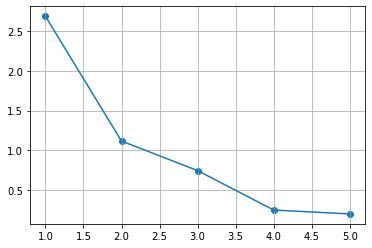

In [749]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=25, rotation=None)
fa.fit(df_culture)
ev, v = fa.get_eigenvalues()
ev

plt.scatter(range(1,df_culture.shape[1]+1),ev)
plt.plot(range(1,df_culture.shape[1]+1),ev)
plt.grid()
plt.show()

### **<span style='background-color:#dcffe4'>탐색적 요인분석 실시</span>**

In [751]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(df_culture)

efa_result = pd.DataFrame(fa.loadings_, index=df_culture.columns)
efa_result['mean'] = (efa_result[0]+efa_result[1])/2
efa_result

,0,1,mean
유적지수,0.094608,0.682175,0.388392
관광명소수,0.344537,0.947611,0.646074
음식점수,1.006275,0.153970,0.580122
쇼핑점수,0.542449,0.120647,0.331548
문화생활인구,0.536098,0.345152,0.440625


In [ ]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(df_culture)

efa_result = pd.DataFrame(fa.loadings_, index=df_culture.columns)
efa_result['mean'] = (efa_result[0]+efa_result[1])/2
efa_result

In [760]:
print('이때 가중치 전체 합은 1을 기준으로 함')
print(" ")
print('관광명소수는 1위로 가중치는', round(0.646074/(0.388392+0.646074+0.580122+0.331548+0.440625),4))
print('음식점수는 2위로 가중치는', round(0.580122/(0.388392+0.646074+0.580122+0.331548+0.440625),4))
print('문화생활인구는 3위로 가중치는', round(0.440625/(0.388392+0.646074+0.580122+0.331548+0.440625),4))
print('유적지수는 4위로 가중치는', round(0.388392/(0.388392+0.646074+0.580122+0.331548+0.440625),4))
print('쇼핑점수는 5위로 가중치는', round(0.331548/(0.388392+0.646074+0.580122+0.331548+0.440625),4))

이때 가중치 전체 합은 1을 기준으로 함
 
관광명소수는 1위로 가중치는 0.2707
음식점수는 2위로 가중치는 0.2431
문화생활인구는 3위로 가중치는 0.1846
유적지수는 4위로 가중치는 0.1627
쇼핑점수는 5위로 가중치는 0.1389


### **<span style='background-color:#dcffe4'>행정동별 문화 지수 출력</span>**

In [769]:
df_culture['문화지수'] = (0.2431*df_culture['유적지수']+0.2707*df_culture['관광명소수']+0.2431*df_culture['음식점수']+0.1389*df_culture['쇼핑점수']+0.1846*df_culture['문화생활인구'])
df_culture

,유적지수,관광명소수,음식점수,쇼핑점수,문화생활인구,문화지수
읍면동명,,,,,,
청운효자동,0.30,0.107914,0.069258,0.151515,0.065110,0.152044
사직동,0.25,0.071942,0.276054,0.257576,0.139997,0.208979
삼청동,0.10,0.100719,0.067625,0.090909,0.046051,0.089143
부암동,0.25,0.201439,0.040183,0.060606,0.046137,0.142008
평창동,0.25,0.273381,0.048024,0.257576,0.014079,0.184830
...,...,...,...,...,...,...
성내제2동,0.00,0.021583,0.131330,0.348485,0.009137,0.087860
성내제3동,0.00,0.021583,0.199935,0.393939,0.015773,0.112076
길동,0.05,0.064748,0.277034,0.530303,0.021500,0.174657


In [775]:
df_culture.sort_values('문화지수', ascending=False)

,유적지수,관광명소수,음식점수,쇼핑점수,문화생활인구,문화지수
읍면동명,,,,,,
종로1.2.3.4가동,1.00,1.000000,0.695851,1.000000,0.577478,0.928464
서교동,0.10,0.187050,0.810519,0.742424,1.000000,0.559705
역삼1동,0.00,0.093525,1.000000,0.696970,0.400660,0.439188
명동,0.05,0.323741,0.413917,0.363636,0.978756,0.431602
여의동,0.00,0.251799,0.614505,0.651515,0.285666,0.360777
...,...,...,...,...,...,...
면목제5동,0.00,0.000000,0.000000,0.000000,0.000751,0.000139
상계8동,0.00,0.000000,0.000000,0.000000,0.000730,0.000135
신월6동,0.00,0.000000,0.000000,0.000000,0.000704,0.000130
